In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import scipy.sparse as sparse
import scipy.linalg as linalg
import numpy as np
import collections
import copy

import amfe
from amfe.utils.utils import OrderedSet
from amfe.cyclic.cyclic import SelectionOperator, apply_cyclic_symmetry, get_all_dofs, rotate_u, set_cyclic_modes_to_component
from amfe.cyclic.cyclic import create_voigt_rotation_matrix, assemble_cyclic_modes, cyclic_symmetry_modal_analysis, Cyclic_Symmetry_Modal_Analysis
from amfe.cyclic.cyclic import create_rotated_component, create_voigt_rotation_matrix, Cyclic_Component
from amfe.utils.utils import get_dofs
from amfe.linalg.arnoldi import arnoldi_iteration, inverse_arnoldi_iteration, general_inverse_arnoldi_iteration, generalized_arnoldi_iteration
from amfe.linalg.arnoldi import lanczos, is_eigvec, nullspace, LinearSys, power_iteration, ProjLinearSys, compute_modes, eigvec_error_vector, is_nullspace
from amfe.linalg.arnoldi import is_moore_pensore_inverse 
from amfe.units import convert
msh_file = r'meshes\one_forth_disk_quad.msh'


m = amfe.Mesh()
m.import_msh(msh_file)


Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.



In [2]:
dirsub = m.get_submesh('phys_group', 7)

cyclic_left = m.get_submesh('phys_group', 5)
cyclic_right = m.get_submesh('phys_group', 6)
domain = m.set_domain('phys_group',9)
domain.split_in_partitions('phys_group')

from ipywidgets import interact
n = len(cyclic_right.global_node_list)-1
@interact(node_id_left=(0,n,1),node_id_right=(0,n,1)) 
def plot_nodes(node_id_left=0,node_id_right=0):
    fig, ax1 = plt.subplots(figsize=(5,5))
    amfe.plot_domain(domain,ax=ax1)
    amfe.plot_submesh(dirsub,ax=ax1,plot_1d=True)
    amfe.plot_submesh(cyclic_left,ax=ax1,plot_1d=True)
    ax1.plot(cyclic_left.get_node_coord(cyclic_left.global_node_list[node_id_left])[0],cyclic_left.get_node_coord(cyclic_left.global_node_list[node_id_left])[1],'o')
    ax1.plot(cyclic_right.get_node_coord(cyclic_right.global_node_list[node_id_right])[0],cyclic_right.get_node_coord(cyclic_right.global_node_list[node_id_right])[1],'o')

interactive(children=(IntSlider(value=0, description='node_id_left', max=5), IntSlider(value=0, description='n…

In [3]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
my_comp.set_domain(9,my_material)

my_comp_copy = copy.deepcopy(my_comp)

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 65 elements and 168 dofs.
Time taken for preallocation: 0.00 seconds.


In [4]:
# get dofs
id_matrix = my_comp.assembly_class.id_matrix
all_dofs = get_all_dofs(id_matrix)
dir_dofs = amfe.get_dofs(dirsub, direction ='xy', id_matrix=id_matrix)

# defining sector angle
theta = np.pi/2.0 #
node_diam = 2
n_modes = 10
n_sector = int((2.0*np.pi)/theta)
# creating node pairs
contact = amfe.Cyclic_Contact(cyclic_left,cyclic_right,sector_angle=theta,unit='rad',tol_radius=000.1)

# modifying order of nodes to have the correct node pairs for cyclic symmetry
cyclic_left.global_node_list = contact.slaves_nodes
cyclic_right.global_node_list = contact.master_nodes


superset = OrderedSet(dir_dofs)
left_dofs = OrderedSet(amfe.get_dofs(cyclic_left, direction ='xy', id_matrix=id_matrix)) - superset
right_dofs = OrderedSet(amfe.get_dofs(cyclic_right, direction ='xy', id_matrix=id_matrix)) - superset


boundary_dofs = superset | left_dofs | right_dofs
interior_dofs = list(OrderedSet(all_dofs) - boundary_dofs)
left_dofs = list(left_dofs)
right_dofs = list(right_dofs)


dof_dict = collections.OrderedDict()
dof_dict['d'] = dir_dofs 
dof_dict['r'] = right_dofs
dof_dict['l'] = left_dofs 
dof_dict['i'] = interior_dofs

s = SelectionOperator(dof_dict,id_matrix)

K, f = my_comp.assembly_class.assemble_k_and_f()
M = my_comp.assembly_class.assemble_m()


M_block = s.create_block_matrix(M)
M_sector = s.assemble_matrix(M,['r','l','i'])

K_block = s.create_block_matrix(K)
K_sector = s.assemble_matrix(K,['r','l','i'])


WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [5]:
K_sector.toarray()

array([[ 1.86755107e+11, -1.28539868e+09,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.28539868e+09,  2.53753381e+11,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.03053680e+11, ...,
        -1.35266190e+10, -5.09665014e+10,  3.89697870e+10],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -1.35266190e+10, ...,
         4.28540686e+11,  2.31913589e+10,  1.84419392e+10],
       [ 0.00000000e+00,  0.00000000e+00, -5.09665014e+10, ...,
         2.31913589e+10,  4.22431702e+11, -8.45019536e+09],
       [ 0.00000000e+00,  0.00000000e+00,  3.89697870e+10, ...,
         1.84419392e+10, -8.45019536e+09,  4.12510634e+11]])

In [6]:
dof_dict2 = collections.OrderedDict()
dof_dict2['r'] = list(range(s.length['r']))
dof_dict2['l'] = list(range(dof_dict2['r'][-1]+1,dof_dict2['r'][-1] + s.length['l']+1))
dof_dict2['i'] = list(range(dof_dict2['l'][-1]+1,dof_dict2['l'][-1] + s.length['i']+1))


# createing selection operator
s2 = SelectionOperator(dof_dict2,id_matrix)

# building cyclic matrices
#theta = -theta
beta = node_diam*theta
ej_beta_plus = np.exp(1J*beta)

#building Boolean matrices
Bl = s2.build_B('l')
Br = s2.build_B('r')
nc, ndof = Br.shape
nr = ndof - nc 
T = create_voigt_rotation_matrix(nc, theta, dim=2)

# Building the cyclic constraint
#C_n = T.dot(Bl) - ej_beta_plus*Br
#C_n = -T.dot(Br) + ej_beta_plus*Bl
C_n =  - ej_beta_plus*Br  + T.dot(Bl) 

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [7]:
#CCT = C_n.dot(M_sector.dot(C_n.conj().T))
CCT = C_n.dot(C_n.conj().T)
CCT_inv = 0.5*sparse.eye(nc) #sparse.linalg.inv(CCT)
computed_CCT_inv = sparse.linalg.inv(CCT.tocsc() )

invertion_error = abs(CCT_inv - computed_CCT_inv).toarray().max()
print('Analytical inverse error = %f' %invertion_error)
P_n = sparse.eye(ndof) - C_n.conj().T.dot(computed_CCT_inv.dot(C_n))
#P_n = sparse.eye(ndof) - C_n.conj().T.dot(computed_CCT_inv.dot(C_n)).dot(M_sector)


R_col1 = (ej_beta_plus.conj()*Br  + T.dot(Bl)).T
R_col2 = sparse.vstack([0*sparse.eye(2*nc,nr-nc).tocsc(), sparse.eye(ndof-2*nc).tocsc()]).tocsc()
R = sparse.hstack([R_col1,R_col2]).tocsc()

Analytical inverse error = 0.000000


<IPython.core.display.Javascript object>


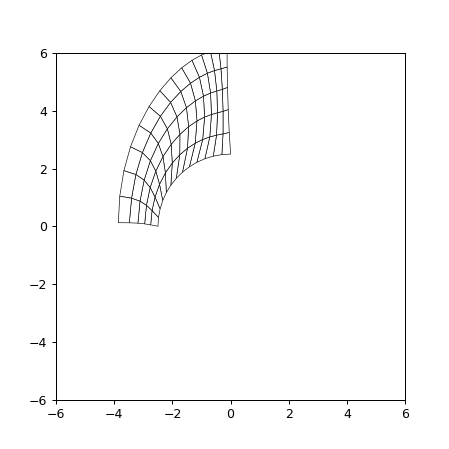

interactive(children=(FloatSlider(value=1.0, description='factor', max=1.0, min=-1.0), IntSlider(value=0, desc…

In [8]:
Kp = P_n.conj().T.dot(K_sector.dot(P_n))
Mp = P_n.conj().T.dot(M_sector.dot(P_n))
Dp_real = np.linalg.pinv(Kp.toarray()).dot(Mp.toarray())

w2, v2 = np.linalg.eig(Dp_real)
new_id = np.argsort(w2)[::-1]
w2 = w2[new_id]
v2 = v2[:,new_id]

u_v = assemble_cyclic_modes(s,v2,node_id=node_diam,compute_left=False,dimension=2)
new_comp2 = copy.deepcopy(my_comp)
new_comp2.u_output = []
new_comp2.u_output = list(u_v.real.T)


fig6,ax6 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot1(factor=1.0,mode_id=0):
    ax6.clear()
    amfe.plot_system_solution(new_comp2, factor=1.0E1*factor, ax = ax6, u_id = mode_id)
    ax6.set_xlim(bc)
    ax6.set_ylim(bc)

In [9]:
Dp_real_s = sparse.csc_matrix(Dp_real)
w2s, v2s = sparse.linalg.eigs(Dp_real_s, k=2*n_modes)
new_id = np.argsort(w2s)[::-1]
w2s = w2s[new_id]
v2s = v2s[:,new_id]

<IPython.core.display.Javascript object>


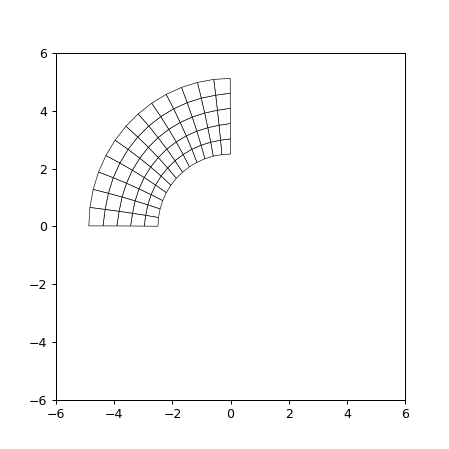

interactive(children=(FloatSlider(value=1.0, description='factor', max=1.0, min=-1.0), IntSlider(value=0, desc…

In [10]:
u_vs = assemble_cyclic_modes(s,v2s,node_id=node_diam,compute_left=False,dimension=2)
new_comp2s = copy.deepcopy(my_comp)
new_comp2s.u_output = []
new_comp2s.u_output = list(u_vs.real.T)


fig7,ax7 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot1(factor=1.0,mode_id=0):
    ax7.clear()
    amfe.plot_system_solution(new_comp2s, factor=1.0E1*factor, ax = ax7, u_id = mode_id)
    ax7.set_xlim(bc)
    ax7.set_ylim(bc)

In [11]:
#RTR_inv = sparse.linalg.inv(R.T.dot(R))
#P_n = R.dot(RTR_inv).dot(R.T)
P_n = 1.0E0*P_n
#P_n_inv = sparse.csc_matrix(np.linalg.pinv(P_n.toarray()))
P_n_inv = sparse.csc_matrix(np.linalg.pinv(P_n.toarray()))
K_inv = sparse.linalg.inv(K_sector)

scipy_K_inv = sparse.csc_matrix(np.linalg.pinv(Kp.toarray()))
#K_pinv = P_n_inv.dot(K_inv.dot(P_n_inv.conj().T))
#K_pinv = P_n.dot(K_inv.dot(P_n.conj().T))
K_pinv = P_n.dot(K_inv).dot(P_n)

#Dp_new =  K_pinv.dot(Mp)
#Dp_new =  scipy_K_inv.dot(Mp)
#Dp_new.dot = lambda b : P_n.dot(sparse.linalg.spsolve(K_sector,Mp.dot(b)))

lo_obj = ProjLinearSys(K_sector,M_sector,P_n)
lo_obj2 = ProjLinearSys(K_sector,M_sector,P_n,precond=scipy_K_inv)
lo_obj3 = ProjLinearSys(K_sector,M_sector,P_n,precond=K_pinv)
lo_obj4 = ProjLinearSys(K_sector,M_sector,P_n,precond=K_inv)
lo_obj5 = ProjLinearSys(K_sector,M_sector,P_n,precond=sparse.diags(1.0/sparse.csr_matrix.diagonal(K_sector),dtype=np.complex))
Dp_new = lo_obj3.getLinearOperator()

In [12]:
w2new, v2new = sparse.linalg.eigs(Dp_new, k=2*n_modes)
new_id = np.argsort(w2new)[::-1]
w2new = w2new[new_id]
v2new = v2new[:,new_id]

<IPython.core.display.Javascript object>


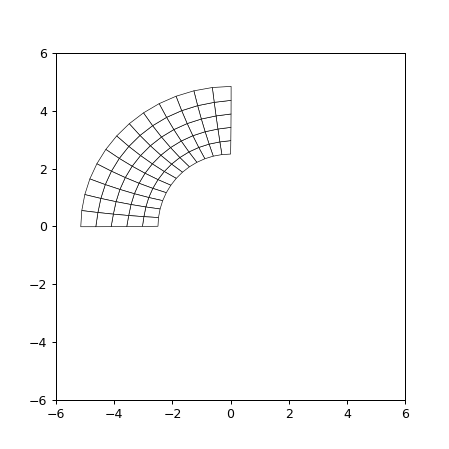

interactive(children=(FloatSlider(value=1.0, description='factor', max=1.0, min=-1.0), IntSlider(value=0, desc…

In [13]:
u_vnew = assemble_cyclic_modes(s,v2new,node_id=node_diam,compute_left=False,dimension=2)
new_comp2new = copy.deepcopy(my_comp)
new_comp2new.u_output = []
new_comp2new.u_output = list(u_vnew.T)


fig8,ax8 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot1(factor=1.0,mode_id=0):
    ax8.clear()
    amfe.plot_system_solution(new_comp2new, factor=1.0E1*factor, ax = ax8, u_id = mode_id)
    ax8.set_xlim(bc)
    ax8.set_ylim(bc)

<IPython.core.display.Javascript object>


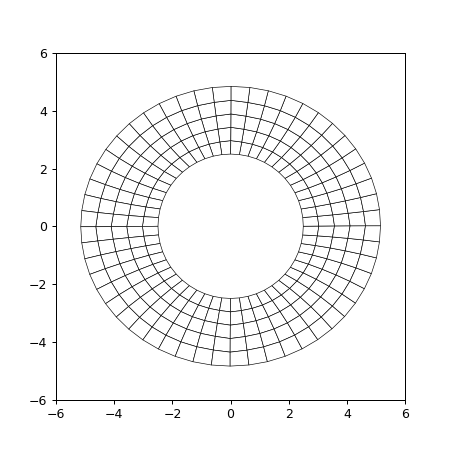

interactive(children=(FloatSlider(value=1.0, description='factor', max=1.0, min=-1.0), IntSlider(value=0, desc…

In [14]:
sector_list = []
for i in range(n_sector):
    sector_i = create_rotated_component(new_comp2new,s,sector_id=i, node_id=node_diam, theta=theta, unit='rad', dimension=2)
    sector_list.append(sector_i)

fig5,ax5 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot2(factor=1.0,mode_id=0):
    ax5.clear()
    for sector_i in sector_list:
        amfe.plot_system_solution(sector_i, factor=10*factor, ax = ax5, u_id = mode_id)
    ax5.set_xlim(bc)
    ax5.set_ylim(bc)

In [15]:
cyclic_comp = Cyclic_Component(my_comp_copy,
                      dirsub,
                      cyclic_left,
                      cyclic_right,
                      sector_angle=theta,
                      unit='rad',
                      tol_radius = 1e-3)

node_diam = 0
P_n_0 = cyclic_comp.build_complex_projection(node_diam)
C_n_0 = cyclic_comp.build_complex_contraint(node_diam)
K_sector_1, M_sector_1 = cyclic_comp.assemble_sector_operators()


xy direction choosen for cyclic symmetry


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [16]:
ep = abs(P_n_0 - P_n).max()
ep

1.0

In [17]:
ec = abs(C_n_0 - C_n).max()
ec

2.0

In [18]:
ek = abs(K_sector_1 - K_sector).max()
ek

0.0

In [19]:
em = abs(M_sector_1 - M_sector).max()
em

0.0

In [20]:
K_sector_1.toarray()

array([[ 1.86755107e+11, -1.28539868e+09,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.28539868e+09,  2.53753381e+11,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.03053680e+11, ...,
        -1.35266190e+10, -5.09665014e+10,  3.89697870e+10],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -1.35266190e+10, ...,
         4.28540686e+11,  2.31913589e+10,  1.84419392e+10],
       [ 0.00000000e+00,  0.00000000e+00, -5.09665014e+10, ...,
         2.31913589e+10,  4.22431702e+11, -8.45019536e+09],
       [ 0.00000000e+00,  0.00000000e+00,  3.89697870e+10, ...,
         1.84419392e+10, -8.45019536e+09,  4.12510634e+11]])

In [21]:
K_sector.toarray()

array([[ 1.86755107e+11, -1.28539868e+09,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.28539868e+09,  2.53753381e+11,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.03053680e+11, ...,
        -1.35266190e+10, -5.09665014e+10,  3.89697870e+10],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -1.35266190e+10, ...,
         4.28540686e+11,  2.31913589e+10,  1.84419392e+10],
       [ 0.00000000e+00,  0.00000000e+00, -5.09665014e+10, ...,
         2.31913589e+10,  4.22431702e+11, -8.45019536e+09],
       [ 0.00000000e+00,  0.00000000e+00,  3.89697870e+10, ...,
         1.84419392e+10, -8.45019536e+09,  4.12510634e+11]])

In [22]:
K, f = my_comp.assembly_class.assemble_k_and_f()
M = my_comp.assembly_class.assemble_m()


M_block = s.create_block_matrix(M)
M_sector = s.assemble_matrix(M,['r','l','i'])

K_block = s.create_block_matrix(K)
K_sector = s.assemble_matrix(K,['r','l','i'])

In [23]:
K_sector.toarray()

array([[ 1.86755107e+11, -1.28539868e+09,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.28539868e+09,  2.53753381e+11,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.03053680e+11, ...,
        -1.35266190e+10, -5.09665014e+10,  3.89697870e+10],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -1.35266190e+10, ...,
         4.28540686e+11,  2.31913589e+10,  1.84419392e+10],
       [ 0.00000000e+00,  0.00000000e+00, -5.09665014e+10, ...,
         2.31913589e+10,  4.22431702e+11, -8.45019536e+09],
       [ 0.00000000e+00,  0.00000000e+00,  3.89697870e+10, ...,
         1.84419392e+10, -8.45019536e+09,  4.12510634e+11]])

In [24]:
nc

10

In [25]:
cyclic_comp.nc

10

In [26]:
cyclic_comp.K.toarray()

array([[ 1.44903683e+11, -3.59862981e+10,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.59862981e+10,  9.22711306e+10,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  9.24027439e+10, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.28540686e+11,  2.31913589e+10,  1.84419392e+10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.31913589e+10,  4.22431702e+11, -8.45019536e+09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.84419392e+10, -8.45019536e+09,  4.12510634e+11]])

In [27]:
K.toarray()

array([[ 1.44903683e+11, -3.59862981e+10,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.59862981e+10,  9.22711306e+10,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  9.24027439e+10, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.28540686e+11,  2.31913589e+10,  1.84419392e+10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.31913589e+10,  4.22431702e+11, -8.45019536e+09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.84419392e+10, -8.45019536e+09,  4.12510634e+11]])

In [28]:
cyclic_comp.M.toarray()

array([[136.2366963 ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 136.2366963 ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 135.78761122, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 833.75542836,
          0.        , 224.14518262],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        981.64436871,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 224.14518262,
          0.        , 981.64436871]])

In [29]:
M.toarray()

array([[136.2366963 ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 136.2366963 ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 135.78761122, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 833.75542836,
          0.        , 224.14518262],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        981.64436871,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 224.14518262,
          0.        , 981.64436871]])

In [30]:
K_sector_2 = cyclic_comp.s.assemble_matrix( cyclic_comp.K,['r','l','i'])

In [31]:
K_sector_2.toarray()

array([[ 1.86755107e+11, -1.28539868e+09,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.28539868e+09,  2.53753381e+11,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.03053680e+11, ...,
        -1.35266190e+10, -5.09665014e+10,  3.89697870e+10],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -1.35266190e+10, ...,
         4.28540686e+11,  2.31913589e+10,  1.84419392e+10],
       [ 0.00000000e+00,  0.00000000e+00, -5.09665014e+10, ...,
         2.31913589e+10,  4.22431702e+11, -8.45019536e+09],
       [ 0.00000000e+00,  0.00000000e+00,  3.89697870e+10, ...,
         1.84419392e+10, -8.45019536e+09,  4.12510634e+11]])

In [32]:
cyclic_comp.K.toarray()

array([[ 1.44903683e+11, -3.59862981e+10,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.59862981e+10,  9.22711306e+10,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  9.24027439e+10, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.28540686e+11,  2.31913589e+10,  1.84419392e+10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.31913589e+10,  4.22431702e+11, -8.45019536e+09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.84419392e+10, -8.45019536e+09,  4.12510634e+11]])

In [33]:
K_sector_3 = s.assemble_matrix( cyclic_comp.K,['r','l','i'])

In [34]:
K_sector_3.toarray()

array([[ 1.86755107e+11, -1.28539868e+09,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.28539868e+09,  2.53753381e+11,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.03053680e+11, ...,
        -1.35266190e+10, -5.09665014e+10,  3.89697870e+10],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -1.35266190e+10, ...,
         4.28540686e+11,  2.31913589e+10,  1.84419392e+10],
       [ 0.00000000e+00,  0.00000000e+00, -5.09665014e+10, ...,
         2.31913589e+10,  4.22431702e+11, -8.45019536e+09],
       [ 0.00000000e+00,  0.00000000e+00,  3.89697870e+10, ...,
         1.84419392e+10, -8.45019536e+09,  4.12510634e+11]])

In [35]:
s.selection_dict

OrderedDict([('d',
              [0,
               1,
               2,
               3,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31]),
             ('r', [64, 65, 68, 69, 70, 71, 66, 67, 6, 7]),
             ('l', [32, 33, 36, 37, 38, 39, 34, 35, 4, 5]),
             ('i',
              [40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
               50,
               51,
               52,
               53,
               54,
               55,
          

In [36]:
cyclic_comp.s.selection_dict

OrderedDict([('d',
              [0,
               1,
               2,
               3,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31]),
             ('r', [64, 65, 68, 69, 70, 71, 66, 67, 6, 7]),
             ('l', [32, 33, 36, 37, 38, 39, 34, 35, 4, 5]),
             ('i',
              [40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
               50,
               51,
               52,
               53,
               54,
               55,
          

In [37]:
Kp.toarray()

array([[ 9.33760863e+10+0.00000000e+00j, -2.33851825e+08+1.65436123e-24j,
         0.00000000e+00+0.00000000e+00j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [-2.33851825e+08+4.70197740e-38j,  1.26660252e+11-9.18354962e-41j,
         0.00000000e+00+0.00000000e+00j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         1.01675254e+11+1.46936794e-39j, ...,
        -6.76330952e+09+0.00000000e+00j, -2.54832507e+10+0.00000000e+00j,
         1.94848935e+10+0.00000000e+00j],
       ...,
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        -6.76330952e+09+0.00000000e+00j, ...,
         4.28540686e+11+0.00000000e+00j,  2.31913589e+10+0.00000000e+00j,
         1.84419392e+10+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.

In [38]:
Mp.toarray()

array([[155.01705379+0.j,   0.        +0.j,   0.        +0.j, ...,
          0.        +0.j,   0.        +0.j,   0.        +0.j],
       [  0.        +0.j, 155.01705379+0.j,   0.        +0.j, ...,
          0.        +0.j,   0.        +0.j,   0.        +0.j],
       [  0.        +0.j,   0.        +0.j, 207.90320006+0.j, ...,
          0.        +0.j,  27.83333062+0.j,   0.        +0.j],
       ...,
       [  0.        +0.j,   0.        +0.j,   0.        +0.j, ...,
        833.75542836+0.j,   0.        +0.j, 224.14518262+0.j],
       [  0.        +0.j,   0.        +0.j,  27.83333062+0.j, ...,
          0.        +0.j, 981.64436871+0.j,   0.        +0.j],
       [  0.        +0.j,   0.        +0.j,   0.        +0.j, ...,
        224.14518262+0.j,   0.        +0.j, 981.64436871+0.j]])

In [39]:
w2s

array([1.65628175e-07+1.57681304e-24j, 1.65608269e-07+1.02832121e-23j,
       7.79840308e-08-1.65105256e-24j, 7.79524403e-08+1.73586744e-24j,
       4.76521656e-08+5.23014164e-24j, 4.76168061e-08+4.58908184e-24j,
       2.05312909e-08+2.45549050e-24j, 2.05295271e-08-9.11191144e-25j,
       1.95226804e-08-2.09124757e-24j, 1.94982911e-08+1.51496518e-24j,
       1.80136025e-08+1.84275940e-24j, 1.79906527e-08+1.99755802e-24j,
       9.62581659e-09+3.08577143e-25j, 9.60958813e-09-3.56741834e-25j,
       8.86585530e-09+1.11488268e-25j, 8.85398871e-09-3.17801276e-25j,
       8.30795805e-09-1.49560224e-24j, 8.29278079e-09+4.63731633e-26j,
       7.92911364e-09-1.55061131e-25j, 7.92167355e-09-1.31050320e-24j])

In [40]:
v2

array([[ 2.48782086e-02+4.93685117e-15j, -1.52908779e-03-9.53111102e-15j,
        -6.68712218e-02-3.42350457e-16j, ...,
        -8.66527300e-02+3.15749992e-02j,  2.66159493e-02+3.98285218e-02j,
         2.66159493e-02-3.98285218e-02j],
       [ 4.76778755e-03-2.85396911e-14j,  7.06702972e-02-2.73363001e-18j,
        -1.54488341e-03+9.21386802e-16j, ...,
        -4.99939388e-02+2.81687139e-02j, -1.25881076e-02+3.21281158e-02j,
        -1.25881076e-02-3.21281158e-02j],
       [ 8.09310824e-02+1.60721213e-14j, -5.00324558e-03-3.10055352e-14j,
        -1.53467493e-01-7.87703108e-16j, ...,
        -1.20926890e-01+3.61518030e-02j, -1.39228145e-01-8.64816470e-02j,
        -1.39228145e-01+8.64816470e-02j],
       ...,
       [ 3.93087175e-02-5.55121129e-14j,  1.49951814e-01-1.11417681e-14j,
         2.87888184e-02-9.03184237e-16j, ...,
        -5.59133080e-17-9.00734944e-16j,  1.86432281e-15+8.27640598e-16j,
         1.86432281e-15-8.27640598e-16j],
       [ 1.01732364e-01+2.10737969e-14j, -8.